# Oxford Man Institute NLP Tutorial 

## 1. Introduction 

There are several ways of performing sentiment classification on a document or article, ranging from word-counts to modern Transformer-based Language Models. In this tutorial we will take you through a range of classification techniques:
- Loughran & McDonald financial sentiment dictionary
- Naive Bayes Classifier
- BERT out of the box
- BERT fine-tuned on general sentiment datasets
- FinBERT 
    - BERT that has been trained on positive and negative financial documents

## 2. Load and analyse the dataset

### Import packages and load dictionaries

In [58]:
import numpy as np
import pandas as pd
import re
import inspect
import csv
import operator
from tutorial_tools import mutual_information
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from collections import defaultdict, Counter

### Load the dataset

In [27]:
df = pd.read_csv('data\\FinancialPhraseBank-v1.0\\Sentences_AllAgree.txt',
            encoding = 'ISO-8859-1',on_bad_lines='skip',sep = '.@', names=['text', 'class'])
df.head()

C:\Users\felix\AppData\Local\Temp\ipykernel_17576\3544662773.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data\\FinancialPhraseBank-v1.0\\Sentences_AllAgree.txt',


,text,class
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


#### Data formatting

The dataset we are using has already been cleaned as it is widely used in the field. If you are using your own custom dataset it may be necessary to clean the text of special characters, URLs, user mentions, emojis etc. 

We will add another columns to our dataset that contains a **tokenised version** of the text as this will form the basis of our Naive Bayes classifier.

In [28]:
token_pattern = re.compile(r"(?u)\b\w\w+\b")
df["tokenised_text"] = df.text.apply(lambda x: token_pattern.findall(x))

**Remove the neutral category** so that we are left with a more extreme examples in our dataset.

In [76]:
df = df[df['class'] != 'neutral']
categories = list(set(df['class']))
categories

['negative', 'positive']

In [30]:
n_negative = df[df['class']=="negative"].shape[0]
prop_negative = df[df['class']=="negative"].shape[0]/df.shape[0]

print(f"{df.shape[0]} entries in the dataset")
print("{} entries / {:.2%} labelled as negative\n".format(n_negative, prop_negative)) 

873 entries in the dataset
303 entries / 34.71% labelled as negative



#### What kind of text are we dealing with?

The Financial PhraseBank was used by Maks and Vossen (2014) in their paper ***"Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts"***. The authors scraped the LexisNexis database for news articles about companies on the OMX Helsinki database.

Although very small, the dataset has since been widely used in the financial community to test and deploy domain specific language models.

In [33]:
for cata in categories:
    cata_df = df[df['class'] == cata]
    cata_lens = cata_df['text'].str.len()
    max_sentence = cata_df[cata_lens == cata_lens.max()]
    with pd.option_context('display.max_colwidth', 500):
        print(f'The longest {cata} sentence is: \n\n', max_sentence['text'], '\n\n')

The longest negative sentence is: 

 2116    Finnish Exel Composites , a technology company that designs , manufactures , and markets composite profiles and tubes for various industrial applications , reports its net sales decreased by 0.6 % in the second quarter of 2010 to EUR 19.2 mn from EUR 19.3 mn in the corresponding period in 2009 
Name: text, dtype: object 


The longest positive sentence is: 

 831    MANAVIGATOR-September 7 , 2010-Kemira unveils Indian JV with IVRCL Finnish chemicals group Kemira ( HEL : KRA1V ) on Tuesday announced it has inked a deal to form a joint venture in India with local construction firm IVRCL Infrastructure and Projects Ltd ( BOM :530773 ) 
Name: text, dtype: object 




#### Data split

In [34]:
train_text, dev_text, test_text = dict(), dict(), dict()

for c_i in categories:
    train_text[c_i], devtest_text = train_test_split(df[df['class']==c_i].tokenised_text,
                                                         train_size=0.7, random_state=123)
    dev_text[c_i], test_text[c_i] = train_test_split(devtest_text,
                                                         train_size=0.5, random_state=123)

Create vocab dict and remove stopwords:

In [35]:
# Create vocab dict
vocab = defaultdict(Counter)
n_text = defaultdict(Counter)

# Create vocabularies
for c_i in categories:
    for text in train_text[c_i]:
        vocab[c_i].update(text)
        n_text[c_i].update(set(text))

# Remove stopwords
stopwords = list()

with open('./data/stopwords.txt', 'r') as fd:
    reader = csv.reader(fd)
    for row in fd:
        stopwords.append(row.replace("\n",""))
        
for c_i in categories:
    for sw in stopwords:
        del vocab[c_i][sw]

#### Inspection of the classes

In [36]:
for c_i in categories:
    print(f"Most common words in {c_i.upper()} class:")
    display(vocab[c_i].most_common(10))
    print()

Most common words in NEGATIVE class:


[('EUR', 174),
 ('mn', 125),
 ('profit', 83),
 ('year', 57),
 ('net', 52),
 ('quarter', 51),
 ('mln', 50),
 ('sales', 50),
 ('2008', 44),
 ('million', 43)]


Most common words in POSITIVE class:


[('EUR', 237),
 ('mn', 157),
 ('profit', 114),
 ('year', 106),
 ('net', 103),
 ('period', 88),
 ('million', 82),
 ('sales', 80),
 ('Finnish', 75),
 ('mln', 71)]

#### Mututal information

Mutual information can help us explain the differences between word distributions. Understanding the features that differentiate a certain category from another can prove very useful for interpretting differences between categories. 

In [37]:
# Calculate the total number of articles in each class, which we will need to calculate mutual information
n_total = dict()
for c_i in categories:
    n_total[c_i] = len(train_text[c_i])

In [38]:
mi_list = sorted([(mutual_information(w, n_text, n_total), w) for w in set(vocab['negative']).union(set(vocab['positive']))], reverse=True)

print('25 overall most informative features:\n\n', [w for mi, w in mi_list][:25])

25 overall most informative features:

 ['fell', 'increased', 'half', '2008', 'nine', 'due', 'EUR', '17', '2007', 'mn', 'quarter', 'eur', 'profit', 'Helsinki', 'first', 'trade', 'prices', 'electronics', '2010', 'excluding', 'items', 'reports', 'negative', 'third', 'order']


## 3. Traditional sentiment analysis

### Loughran & McDonald classifier

Loughran & McDonald released their master dictionary in 2011 in conjunction with their paper “When is a Liability not a Liability? Textual Analysis, Dictionaries, and 10-Ks". The dictionary lists a number of words and includes negative, positive, uncertainty, litigious, strong modal, weak modal, and constraining tags. 

There are several shortcomings to this simplistic approach:

- **Some words don't appear in the dictionary (fall, rise, etc.)**
- **Some words are negative/positive given the context they are written (profit, expenditure, etc.)**
- **Simple counts of words don't necessarily infer the overall sentiment**
    - *Hatred for football has always confused me; there are so many haters who attack the sport, but I have always loved it.* - 3 negative words and 1 positive word.


We have taken the words that have a negative and positive tag for our classifier:

In [39]:
lmdict = np.load('data/LoughranMcDonald_dict.npy', allow_pickle='TRUE').item()
print('Some examples of negative words: ', lmdict['Negative'][:5])
print('Some examples of positive words: ', lmdict['Positive'][:5])

Some examples of negative words:  ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments']
Some examples of positive words:  ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish']


In [40]:
lmdict['Positive'][:5]

['able', 'abundance', 'abundant', 'acclaimed', 'accomplish']

Check to see if a word appears in the dictionary:

In [41]:
word = 'fall'

if word in lmdict['Negative']:
    print(f'Yes, {word} is a Negative word in the Loughran & McDonald dictionary')
elif word in lmdict['Positive']:
    print(f'Yes, {word} is Positive word in the Loughran & McDonald dictionary')
else:
    print(f'No, {word} is not in the Loughran & McDonald dictionary')

No, fall is not in the Loughran & McDonald dictionary


Negation is another challenge that emerges using this approach. A techy fix is to check if the word is preceeded by a negating word in our list:

In [42]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [43]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

This function counts the number of negative and positive words in a document and performs a negation check to switch the polarity of words that are preceeded by a word in the *negate* list.

In [44]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
                
    sentiment_score = len(pos_words) - len(neg_words)
    
    if sentiment_score < 0:
        classification = 'negative'
    elif sentiment_score > 0:
        classification = 'positive'
    else:
        classification = 'neutral'
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words, classification]
 
    return results
 
    
# A sample output
article = '''The stock market has had its worst start to a year in recent history and things could get 
             worse as recession fears loom. Since World War II there have been 13 recessions—defined as 
             two consecutive quarters of GDP decline–and there have been 3 in the 21st century (2001, 2008 and 2020), 
             according to the National Bureau of Economic Research. Some experts say another one could be on the way.'''
 
sent_results = tone_count_with_negation_check(lmdict, article)

print('The results with negation check:', end='\n\n')
print('The # of positive words:', sent_results[1])
print('The # of negative words:', sent_results[2])
print('The list of found positive words:', sent_results[3])
print('The list of found negative words:', sent_results[4])
print('The overall classification is:', sent_results[5])

The results with negation check:

The # of positive words: 0
The # of negative words: 6
The list of found positive words: []
The list of found negative words: ['worst', 'worse', 'recession', 'fears', 'recessions', 'decline']
The overall classification is: negative


Sometimes this technique can be successful, but there are many examples where it falls short. For example, when we use a clearly negative text that doesn't contain any words in the lexicon.

In [45]:
article = '''Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that 
             were hit by larger expenditures on R&D and marketing'''
 
sent_results = tone_count_with_negation_check(lmdict, article)

print('The results with negation check:', end='\n\n')
print('The # of positive words:', sent_results[1])
print('The # of negative words:', sent_results[2])
print('The list of found positive words:', sent_results[3])
print('The list of found negative words:', sent_results[4])
print('The overall classification is:', sent_results[5])

The results with negation check:

The # of positive words: 0
The # of negative words: 0
The list of found positive words: []
The list of found negative words: []
The overall classification is: neutral


#### Performance on the Financial PhraseBank dataset

In [46]:
labels = list(df['class'])
predictions= list()

for phrase, c_i in zip(df['text'], df['class']):
    sent_results = tone_count_with_negation_check(lmdict, phrase)
    classification = sent_results[5]
    predictions.append(classification)

In [47]:
neutral_count = predictions.count('neutral')
positive_count = predictions.count('positive')
negative_count = predictions.count('negative')

print(f'We passed {len(predictions)} examples through the LM classifier \n')
print(f'There were {neutral_count} NEUTRAL predictions')
print(f'There were {positive_count} POSITIVE predictions')
print(f'There were {negative_count} NEGATIVE predictions')

We passed 873 examples through the LM classifier 

There were 573 NEUTRAL predictions
There were 101 POSITIVE predictions
There were 199 NEGATIVE predictions


In [48]:
print(classification_report(labels, predictions, digits=3))

              precision    recall  f1-score   support

    negative      0.613     0.403     0.486       303
     neutral      0.000     0.000     0.000         0
    positive      0.921     0.163     0.277       570

    accuracy                          0.246       873
   macro avg      0.511     0.189     0.254       873
weighted avg      0.814     0.246     0.350       873



C:\Users\felix\anaconda3\envs\OMI_NLP_workshop\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix\anaconda3\envs\OMI_NLP_workshop\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix\anaconda3\envs\OMI_NLP_workshop\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results so far

| **Model name**        | **Loughram McDonald** |
|-----------------------|-----------------------|
| **Averaged F1 Score** | 0.2544                |


### Naive Bayes classifier

A NB classifier improves upon the lexicon technique explored above as it utilises the individual contribution of each word in the text. The fundamental training goal of a NB classifier is to calculate the individual probability of a word appearing in a particular class, $P(w|c_i)$, and summing the log probability of each word to discern $P(d|c_i)$. 

There are some assumptions and training details in our model:
- Add-one smoothing - assume that all words appear once in each class so that one can calculate the probability for a word appearing.
    - Large oversimplification but it is necessary for both classes to have the same support.
- Remove all stop words - probability distribution of stop words doesn't neccessarily discern sentiment classification.
    - she, he, it, so, I, etc. 
    
##### Advantages and disadvatanges:
    
<font color='green'>$\checkmark$</font>   Granular feature set \
<font color='green'>$\checkmark$</font>   Can also include bigrams, trigrams, emojis etc. for improved performance 

#### Training the classifier

In [77]:
# Naive Bayes with additive smoothing
# Define function to get P(w|c_i), class-conditional propbabilities for w

def naive_bayes_additive_smoothing(vocab, categories, smoothing_alpha):
    
    # Calculate unsmoothed probabilities
    probabilities = dict()
    
    for c_i in categories:
        
        probabilities[c_i] = dict()
        
        # First, consider all words that are in the vocab for either class
        for word in set(vocab["negative"]).union(set(vocab["positive"])):
            # If they do exist in the current class c_i, store their count --> 1st order model
            if vocab[c_i][word]>0:
                probabilities[c_i][word] = vocab[c_i][word]
            # If not, set their count to be the smoothing parameter (rather than excluding them, as we did for no smoothing) --> backoff to 0th order model
            else:
                probabilities[c_i][word] = smoothing_alpha
        
        # Second, we take the sum of counts of words in this new dict
        total = sum(probabilities[c_i].values())
        
        # Last, we turn the counts for each word into probabilities by dividing them by that sum
        probabilities[c_i] = {word: probabilities[c_i][word] / total for word in probabilities[c_i]}
    
    return probabilities

Estimate the probability of the class:

In [78]:
# Estimate P(c_i), the probability of class c_i, based on the class distribution in the test set
prob_class = dict()
for c_i in categories:
    prob_class[c_i] = train_text[c_i].shape[0]/(train_text["negative"].shape[0]+train_text["positive"].shape[0])

Retrieve the predictions:

In [79]:
def get_nb_predictions(categories, test_tweets, probabilities, prob_class):

    # Initialize lists for storing ground truth labels and predictions
    labels = list()
    predictions = list()

    # Loop over categories
    for c_i in categories:

        # Loop over test tweets
        for tweet in test_tweets[c_i]:

            # Store ground truth
            labels.append(c_i)

            # For each post, calculate scores for each of the two categories
            scores = {'negative': 0, 'positive': 0}
            for word in tweet:
                if word in probabilities[c_i]:
                    scores["negative"] += np.log(probabilities["negative"][word])
                    scores["positive"] += np.log(probabilities["positive"][word])

            # Class imbalance
            scores["negative"] = scores["negative"]+np.log(prob_class["negative"])
            scores["positive"] = scores["positive"]+np.log(prob_class["positive"])

            # Use higher score for prediction
            predictions.append(max(scores.items(), key=operator.itemgetter(1))[0])

    return labels, predictions

### Exercise: tuning the smoothing-alpha parameter

For this exercise you should try and find the best smoothing-alpha value that will result in the highest macro-F1 score.


Step 1) Create a data object of smoothing-alpha values that we can loop over. What values and steps seem reasonable/are possible?

In [84]:
smoothing_alphas = [0.0000000001]+[x * 0.05 for x in range(1, 21)]

Step 2) Loop over the smoothing-alpha values to calculate the macro-f1 score at each value.

In [96]:
macro_f1_dict = dict()

for smoothing_alpha in smoothing_alphas:
    
    probs = naive_bayes_additive_smoothing(vocab, categories, smoothing_alpha)
    
    labels, predictions = get_nb_predictions(categories, dev_text, probs, prob_class)
    
    macro_f1_dict[smoothing_alpha] = f1_score(labels, predictions, average="macro")

Step 3) Find the best and worst smoothing-alpha values and identify the difference between the respective macro-f1 scores.

In [97]:
best_param, worst_param = max(macro_f1_dict, key=macro_f1_dict.get), min(macro_f1_dict, key=macro_f1_dict.get)
best_f1, worst_f1 = max(macro_f1_dict.values()), min(macro_f1_dict.values())

print(f"Smoothing parameter {best_param} produces the HIGHEST macro F1 on the dev set: {best_f1}")
print(f"Smoothing parameter {worst_param} produces the LOWEST macro F1 on the dev set: {worst_f1}")
print(f"The difference between the highest and lowest macro F1 is {best_f1-worst_f1}.")

Smoothing parameter 0.75 produces the HIGHEST macro F1 on the dev set: 0.7833333333333334
Smoothing parameter 1e-10 produces the LOWEST macro F1 on the dev set: 0.7322437047372268
The difference between the highest and lowest macro F1 is 0.05108962859610666.


Step 4) Plot smoothing-alphas vs. macro-f1 socre so we can visualise and interpret the best smoothing-alphas. 

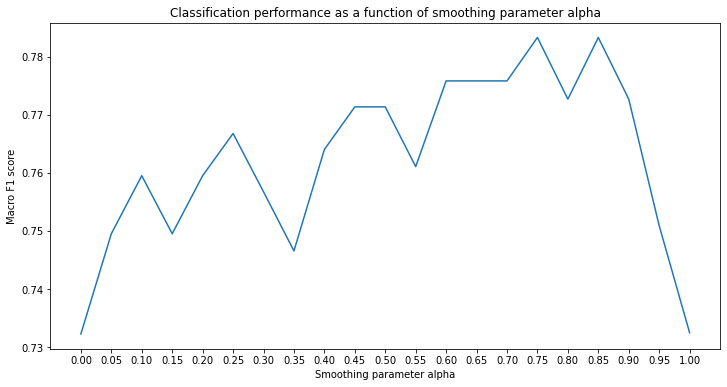

In [98]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt_x, plt_y = list(), list()

for key in macro_f1_dict:
    plt_x.append(key)
    plt_y.append(macro_f1_dict[key])

ax.plot(plt_x, plt_y)

ax.set_title('Classification performance as a function of smoothing parameter alpha')
ax.set_xlabel('Smoothing parameter alpha')
ax.set_ylabel('Macro F1 score')
ax.set_xticks(smoothing_alphas)

plt.show()

Step 5) Input the best performing smoothing-alpha to make our predictions on the test set

In [100]:
# Train
probs = naive_bayes_additive_smoothing(vocab, categories, smoothing_alpha=best_param)

# Get predictions on dev set
labels, predictions = get_nb_predictions(categories, test_text, probs, prob_class)

# Calculate and store macro F1 on test set
print(classification_report(labels, predictions, digits=3))
print(f1_score(labels, predictions, average='macro'))

              precision    recall  f1-score   support

    negative      0.625     0.652     0.638        46
    positive      0.810     0.791     0.800        86

    accuracy                          0.742       132
   macro avg      0.717     0.721     0.719       132
weighted avg      0.745     0.742     0.744       132

0.7191489361702128


# Results so far

| **Model name**        | **Loughram McDonald** | **Naive Bayes** | 
|-----------------------|-----------------------|-----------------|
| **Averaged F1 Score** | 0.2544                | 0.71|

## 3. BERT classification

In [1]:
# Import all dependencies 
#from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import sklearn 
from sklearn.manifold import TSNE
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
# huggingface transformers --> see on the website 
from transformers import AutoTokenizer,logging
from transformers import AutoModelForSequenceClassification, AutoTokenizer,BertForMaskedLM,AutoTokenizer
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import AutoConfig
from scipy.spatial.distance import cosine
import warnings

import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

C:\Users\drago\anaconda3\envs\tutorialenvcuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!conda install pytorch cudatoolkit=11.3 -c pytorch -c nvidia

In [3]:
torch.cuda.is_available()

True

In [4]:
logging.set_verbosity(50)

In [5]:
# Import the dataset from huggingfaces' dataset repository
#fin_dataset = load_dataset('financial_phrasebank', 'sentences_allagree')
#df = pd.DataFrame(fin_dataset['train']) # send  it to a pandas dataframe

# If you are having issues running the code above on Windows, don't worry this is a known Huggingface error-
# Please use the code below which wille import the data we were planning to use from a .txt file

#origin of this data : data/FinancialPhraseBanl-v1.0

df = pd.read_csv('data\\FinancialPhraseBank-v1.0\\Sentences_50Agree.txt',
            encoding = 'ISO-8859-1',sep = '.@')
df.columns = ['sentence','label']
df['label'] = df['label'].replace(to_replace=({'neutral':2,'positive':0,'negative':1}))
df['label']= df['label'].astype(int)

In [6]:
# to make the task comparable to the Bayesian classifier above we will also drop the neutral class 

df = df[df['label']!=2]

In [7]:
### Tokenizer 

In [8]:
df.label.value_counts(normalize = True)

0    0.692933
1    0.307067
Name: label, dtype: float64

In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# loading in a different tokenizer for a different model is as easy as :  
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [10]:
#how does the tokenizer work ? 
print('\nThis is our input sentence : \n "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank." \n')

out = tokenizer(["After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."],
          max_length=32,padding="max_length", truncation=True,return_tensors='pt')
print('These are the outputs of the tokenizer:\n')
print(out)

print('\nThese inputs correspond to the original sentence with separation and padding thrown in :\n')
print(tokenizer.decode(out['input_ids'][0]))


This is our input sentence : 
 "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank." 

These are the outputs of the tokenizer:

{'input_ids': tensor([[  101,  1258, 11569,  1948,  1121,  1103,  3085, 13454,   117,  1103,
          3085,   187, 12809,  3169,  1108,  1562,  5339,  1113,  1103,  5201,
          2186,  3085,   119,   102,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0]])}

These inputs correspond to the original sentence with separation and padding thrown in :

[CLS] After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [11]:
# Now that we covered  the tokenizer lets introduce the other building block : the model 

print('this is our model : \n')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')
# just as for the tokenizer, loading in a different model follows the same syntax : 

finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
layers = [i for i in model.parameters()]
print('\n First layer shape (vocabulary size) : \n ',layers[0].shape,
      '\n Number of self attention heads: ',len([i.shape  for i in layers if (i.shape==torch.Size([3072])) ]),
'\n Last layer shape (prediction task output shape) : \n ',layers[-1].shape)

this is our model : 


 First layer shape (vocabulary size) : 
  torch.Size([28996, 768]) 
 Number of self attention heads:  12 
 Last layer shape (prediction task output shape) : 
  torch.Size([2])


In [12]:
# basic forward propagation of our BERT model 
print('This is our forward propagation syntax. \n We feed in a tokenized text and receive the \n predicted  logits over the 2 classes : \n')
model_output = model.forward(**out,output_hidden_states=True,output_attentions=True)
print('model outputs',model_output.logits)
#by setting outuput_hidden_states as true we also get the layer-by-layer hidden representations 
# lets see the shape of the hidden layers
print("shape of one of the model's hidden layers",[i.shape for i in model_output.hidden_states][0])
# They are all batchsize x sequence length x embedding length = 1 x 32 x 768

#by setting output_attentions as true we also get the layer-by-layer attention scores 
# lets see the shape of the attention scores
print("shape of one of the model's attention layers",[i.shape for i in model_output.attentions][0])
# They are all batchsize x attention_heads x sequence length x sequence_length = 1 x 12 x 32 x 32

This is our forward propagation syntax. 
 We feed in a tokenized text and receive the 
 predicted  logits over the 2 classes : 

model outputs tensor([[-0.0730, -1.3376]], grad_fn=<AddmmBackward0>)
shape of one of the model's hidden layers torch.Size([1, 32, 768])
shape of one of the model's attention layers torch.Size([1, 12, 32, 32])


# Recap : BERT works with two main pillars : 
* Tokenizers go from the text to the embedding space 
* Model goes from the embedding space to the hidden representation 
These two parts are 'pre-trained' before the fine tuning stage

Finetuning adds a fully connected layer at the end of this frozen representation and learns to map it to the data

<img src="BERT-classification-spam.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />

# Maybe this feels a bit abstract, lets do a visualization excercise
We will first work with : 
* Pretrained tokenisation ( the embedding layer ) + Hands on coding of word embedding similarity 
* Hidden layers (layers 1 through 12 ) + Hands on coding of word hidden representation similarity & sentence hidden representation similarity
* Attention attention matrices (layers 1 through 12 ) + Hands on coding of attention-attention matrices 



## First lets look at the initial embedding vectors

In [13]:
# remember, when we use 'tokens' we manipulate the keys to 
# a huge dictionnary of embeddings that constitute the 
# high-dimensional pre-trained vector representation of our words 

# let's see what our sentence would look like as vectors instead of tokens
display(layers[0][out['input_ids'][0]])
print('shape of passed sentence',layers[0][out['input_ids'][0]].shape) # stacked tensors of dimension : sentence_length x vector length (32x 768)
cols = out['input_ids'][0].numpy()
cols = [tokenizer.decode(i) for i in cols]

tensor([[ 0.0333,  0.0066, -0.0037,  ...,  0.0043, -0.0085, -0.0164],
        [-0.0136,  0.0381,  0.0037,  ..., -0.0591,  0.0329, -0.0294],
        [ 0.0195, -0.0921,  0.0751,  ..., -0.0457, -0.0474, -0.0370],
        ...,
        [-0.0005, -0.0416,  0.0131,  ..., -0.0039, -0.0335,  0.0150],
        [-0.0005, -0.0416,  0.0131,  ..., -0.0039, -0.0335,  0.0150],
        [-0.0005, -0.0416,  0.0131,  ..., -0.0039, -0.0335,  0.0150]],
       grad_fn=<IndexBackward0>)

shape of passed sentence torch.Size([32, 768])


Text(0.5, 1.0, 'Heatmap of the embedding values of our tutorial sentence')

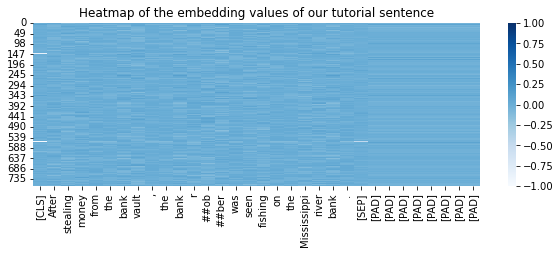

In [16]:
plt.subplots(figsize = (10,3))
sns.heatmap(pd.DataFrame(layers[0][out['input_ids'][0]].detach().cpu().numpy(),index = cols).T,cmap = 'Blues',vmax = 1,vmin =-1)
plt.title('Heatmap of the embedding values of our tutorial sentence')

Text(0.5, 1.0, 'Heatmap of the embedding values of our tutorial sentence on another model')

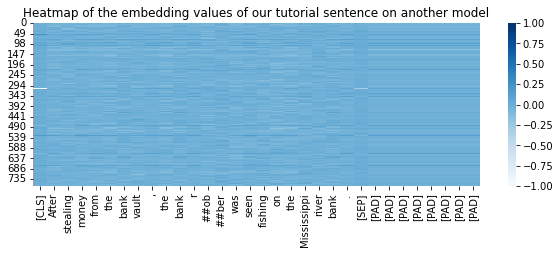

In [17]:
# lets look at another tokenizer-model pair to check if that still holds 
# --> reuse the code above to make the same plot for the finbert model instead 
finbert_out = finbert_tokenizer(["After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."],
          max_length=32,padding="max_length", truncation=True,return_tensors='pt')
finbert_model_output = finbert_model.forward(**finbert_out,output_hidden_states=True,output_attentions=True)
f_cols = finbert_out['input_ids'][0].numpy()
f_cols = [finbert_tokenizer.decode(i) for i in f_cols]
f_layers =  [i for i in finbert_model.parameters()]
plt.subplots(figsize = (10,3))
sns.heatmap(pd.DataFrame(f_layers[0][out['input_ids'][0]].detach().cpu().numpy(),index = cols).T,cmap = 'Blues',vmax = 1,vmin =-1)
plt.title('Heatmap of the embedding values of our tutorial sentence on another model')

#### Hands on coding : look at how the model represents closeness / distance of words over the initial embedding space

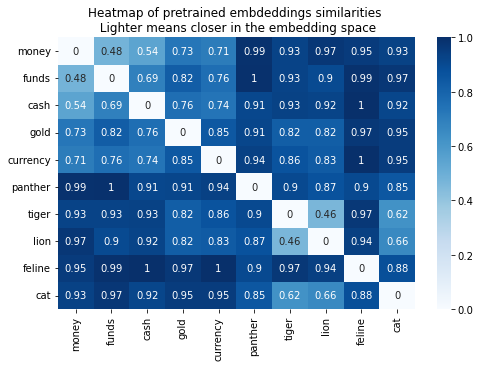

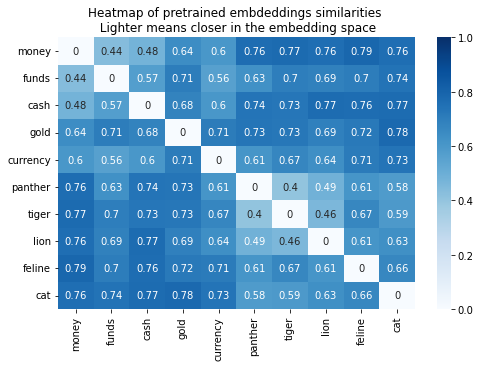

In [18]:
# While getting all of the cosine similarities would be computationally very expensive, 
# try looking at cosine similarities of these embeddings in either model between different words
# Try to find words that you'd expect to be similar to each other 
# (hint try something from finance and something completely outside of it)

def word_proximity_comparison(model = model,tokenizer = tokenizer,wordlist = ['money','funds','cash','gold','currency',
                                                        'panther','tiger','lion','feline','cat']):
    
    """
    Function to compute cosine distance matrix of the embeddings of different words to visualise the quality of our embeddings 
    """
    out = tokenizer(wordlist,
              max_length=3,padding="max_length", truncation=True,return_tensors='pt')
    
    
    layers =  [i for i in model.parameters()]

    plt.subplots(figsize = (8,5))
    cosine_distance_matrix = sklearn.metrics.pairwise.cosine_distances(X =layers[0][out['input_ids'][:,1]].detach().cpu().numpy() )
    sns.heatmap(pd.DataFrame(cosine_distance_matrix,columns = wordlist,index = wordlist),cmap='Blues',annot = cosine_distance_matrix ,vmax=1,vmin = 0 )
    plt.title('Heatmap of pretrained embdeddings similarities \n Lighter means closer in the embedding space')
    


word_proximity_comparison()
word_proximity_comparison(model = finbert_model,tokenizer = finbert_tokenizer)

## Now after the embeddings we look at the hidden layers

In [19]:
# there are 13 layers in all : 1 from the embeddings to hidden and 12 hiddenn layers 
# we looked at the 1st layer in the first stage of this visualisation exercise
# we only want the last 12 --> we want to see how the model represents text beyond the vector representation 
out = tokenizer(["After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."],
          max_length=32,padding="max_length", truncation=True,return_tensors='pt')
model_output = model.forward(**out,output_hidden_states=True,output_attentions=True)
hidden_states = model_output.hidden_states[1:] 

Text(0.5, 1.0, 'Distribution of the hidden weights of a token n*1 at layer 0')

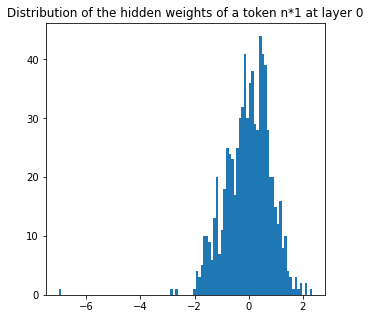

In [20]:
# lets look at the distribution of these weights just to have an idea 
# --> move the indices around in the code below to look at the representation of different words 
which_batch=0
which_layer=0
which_word =1
hidden_vectors = hidden_states[which_batch][which_layer][which_word].detach().cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist(hidden_vectors,bins = 100)
plt.title(f'Distribution of the hidden weights of a token n*{which_word} at layer {which_layer}')

#### Hands-on coding : chose which layers of the hidden embedding to average out 

In [22]:
stacked_embeddings = torch.stack(hidden_states,dim=0).squeeze() # a stack with every hidden layer dimensionality : hidden_layers x sequence length x vector length

stacked_embeddings = stacked_embeddings.permute(1,0,2)# switch tokens and hidden layer dimensions around 

# we'll grab the last 4 layers --> feel free to play around with this to sum up, averate out or concatenate whatever layers you want 
stacked_embeddings_summed = torch.sum(stacked_embeddings[:,-4:,:],dim = 1).detach().cpu().numpy()


#stacked_embeddings_summed[6]#bank vault
#stacked_embeddings_summed[10]#bank robber
#stacked_embeddings_summed[19]#river bank



# This is the cosine similarity for different meanings of the word bank : the robbed bank vs the rivers' bank
diff_bank = 1 - cosine(stacked_embeddings_summed[10], stacked_embeddings_summed[19])

# This is the cosine similarity for similar meanings of the same word : the robbed bank 
same_bank = 1 - cosine(stacked_embeddings_summed[10], stacked_embeddings_summed[6])

print('Cosine similarity  *same*  meanings - higher = closer:  %.2f' % same_bank)
print('Cosine similarity for *different* meanings - higher = closer:  %.2f' % diff_bank)

print('The same meaning has similar ')



Cosine similarity  *same*  meanings - higher = closer:  0.90
Cosine similarity for *different* meanings - higher = closer:  0.68
The same meaning has similar 


<AxesSubplot:>

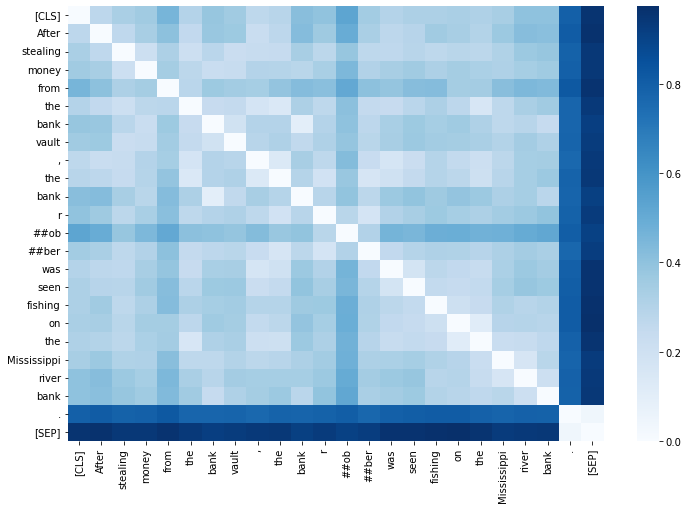

In [23]:
cosine_distance_matrix = sklearn.metrics.pairwise.cosine_distances(X =stacked_embeddings_summed )
cosinedf = pd.DataFrame(cosine_distance_matrix,columns=cols,index = cols)
cosinedf = cosinedf.drop('[PAD]',axis = 0).drop('[PAD]',axis = 1)
plt.figure(figsize = (12,8))
sns.heatmap(cosinedf,cmap = 'Blues')

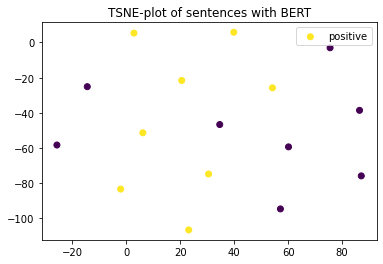

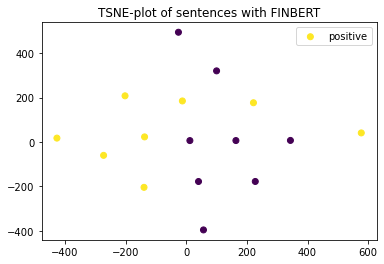

In [478]:
# Have a look at the way bert separates between these setences in a context-aware maner before the classification layer
sentence_list =[
'stocks are up recently',#positive
'stocks are down recently',#negative
'costs are up recently',#negative
'costs are down recently',#positive
'margins are up recently',#positive
'margins are down recently',#negative
'earnings are up recently',#positive
'earnings are down recently',#negative
'stocks are not up recently',#negative
'stocks are not down recently',#positive
'costs are not up recently',#positive
'costs are not down recently',#negative
'margins are not up recently',#negative
'margins are not down recently',#positive
'earnings are not up recently',#negative
'earnings are not down recently'#positive
]
def scatterplot_of_sentences(model = model,tokenizer=tokenizer,
                             sentence_list=sentence_list,
                             labels = [1,0,0,1,1,0,1,0,0,1,1,0,0,1,0,1],
                            title = 'TSNE-plot of sentences',
                            which_layers = 11):
    
    """
    Function to produce a scatterplot based on a TSNE information 
    compression of the 768 dimension of the hidden layer representation of the sentences
    Approximates what our sequential layer will receive. 
    Plots out the tsne compression of the hidden layer 
    
    model : transformers model used to get hidden layers from 
    tokenizer : transformers tokenizer used to get tokenized embeddings from 
    sentence_list : list of target sentences
    labels : list of labels for the sentence's class ( their sentiment )
    title : title of the resulting plot
    which_layers : integer counting the number of hidden layers to average out
    
    """
    
    out = tokenizer(sentence_list,
              max_length=32,padding="max_length", truncation=True,return_tensors='pt')
    model_output = model.forward(**out,output_hidden_states=True,output_attentions=True)
    hidden_states = model_output.hidden_states[1:] 

    stacked_multiple_sentences = torch.stack(hidden_states,dim = 0)
    stacked_multiple_sentences = stacked_multiple_sentences.permute(1,0,2,3)
    averaged_last_layers = torch.mean(stacked_multiple_sentences[:,-which_layers:,:,:],dim = 1)
    
    sentence_averaging = torch.mean(averaged_last_layers,dim = 1)
    X = sentence_averaging.detach().cpu().numpy()
    X_embedded = TSNE(n_components=2,metric = 'cosine', init='random').fit_transform(X)
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c = labels)
    plt.title(title)
    plt.legend(['positive'])
    plt.show()

    
scatterplot_of_sentences(title = 'TSNE-plot of sentences with BERT')
scatterplot_of_sentences(model = finbert_model,tokenizer=finbert_tokenizer,title = 'TSNE-plot of sentences with FINBERT')

#### Hands-on coding : Explore how bert separates out sentences 'in context' before the final layer
The previous plotting above is instructive but lets look at a less artificial example with our input data 

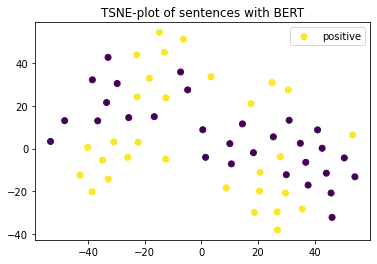

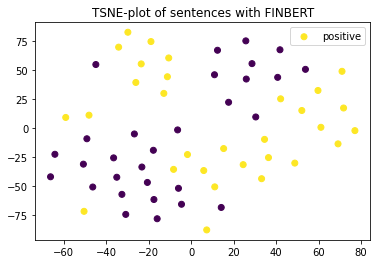

In [479]:
# Please use the dataset imported above to create a list of sentences you will then feed our scatterplot function
# Hint : the dataset is very imbalanced so you could use something like df[df.label==1] to slice the dataframe and get
#        balanced classes that you will actually 

l1 = df[df.label==1].sentence.tolist()[0:30]
label1 = df[df.label==1].label.tolist()[0:30]
l1.extend(df[df.label==0].sentence.tolist()[0:30])
label1.extend(df[df.label==0].label.tolist()[0:30])

scatterplot_of_sentences(sentence_list=l1,labels = label1,title = 'TSNE-plot of sentences with BERT')
scatterplot_of_sentences(model = finbert_model,tokenizer=finbert_tokenizer,
                         sentence_list=l1,labels = label1,title = 'TSNE-plot of sentences with FINBERT')


## After the hidden layers' contextual information let us look at the attention plots

In [28]:
# lets plot the first attention-attention plot
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

out = tokenizer(["After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."],
          max_length=32,padding="max_length", truncation=True,return_tensors='pt')


model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')

model_output = model.forward(**out,output_hidden_states=True,output_attentions=True)

cols = out['input_ids'][0].numpy()
cols = [tokenizer.decode(i) for i in cols]


def plot_attention_attention(matrix,columns,axis = None):
    """
    This is a function to plot out an attention-attention matrix 
    in a pleasant format to identify quickly what parts of the sentence
    the model learns to attend to.
    
    matrix : a pytorch 32 x 32 matrix
    columns : a list of the decoded tokens 
    axis : an axis parameter for plotting 
    """
    
    firstattentionattentiondata = pd.DataFrame(matrix.detach().cpu().numpy(),#select the attention-attention matrix
             columns =columns,
             index = columns)
    firstattentionattentiondata=firstattentionattentiondata.drop(['[PAD]'], axis = 1).drop(['[PAD]'], axis = 0)
    
    if axis == None : 
        f,ax = plt.subplots(1,1,figsize = (5,5))
        sns.heatmap(firstattentionattentiondata,cmap = 'Blues',ax = axis,cbar = False)
        plt.title('Attention attention plot of the first attention head ')
        plt.show()
    else : 
        sns.heatmap(firstattentionattentiondata,cmap = 'Blues',ax = axis,cbar = False)

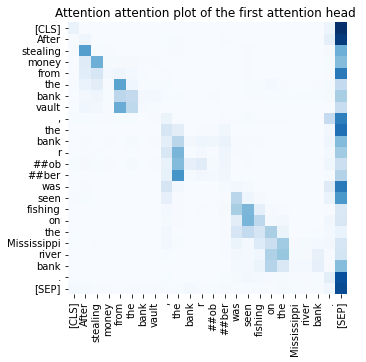

In [39]:
plot_attention_attention(matrix = model_output.attentions[8][0][0], columns =cols,axis = None)

12it [04:11, 20.92s/it]


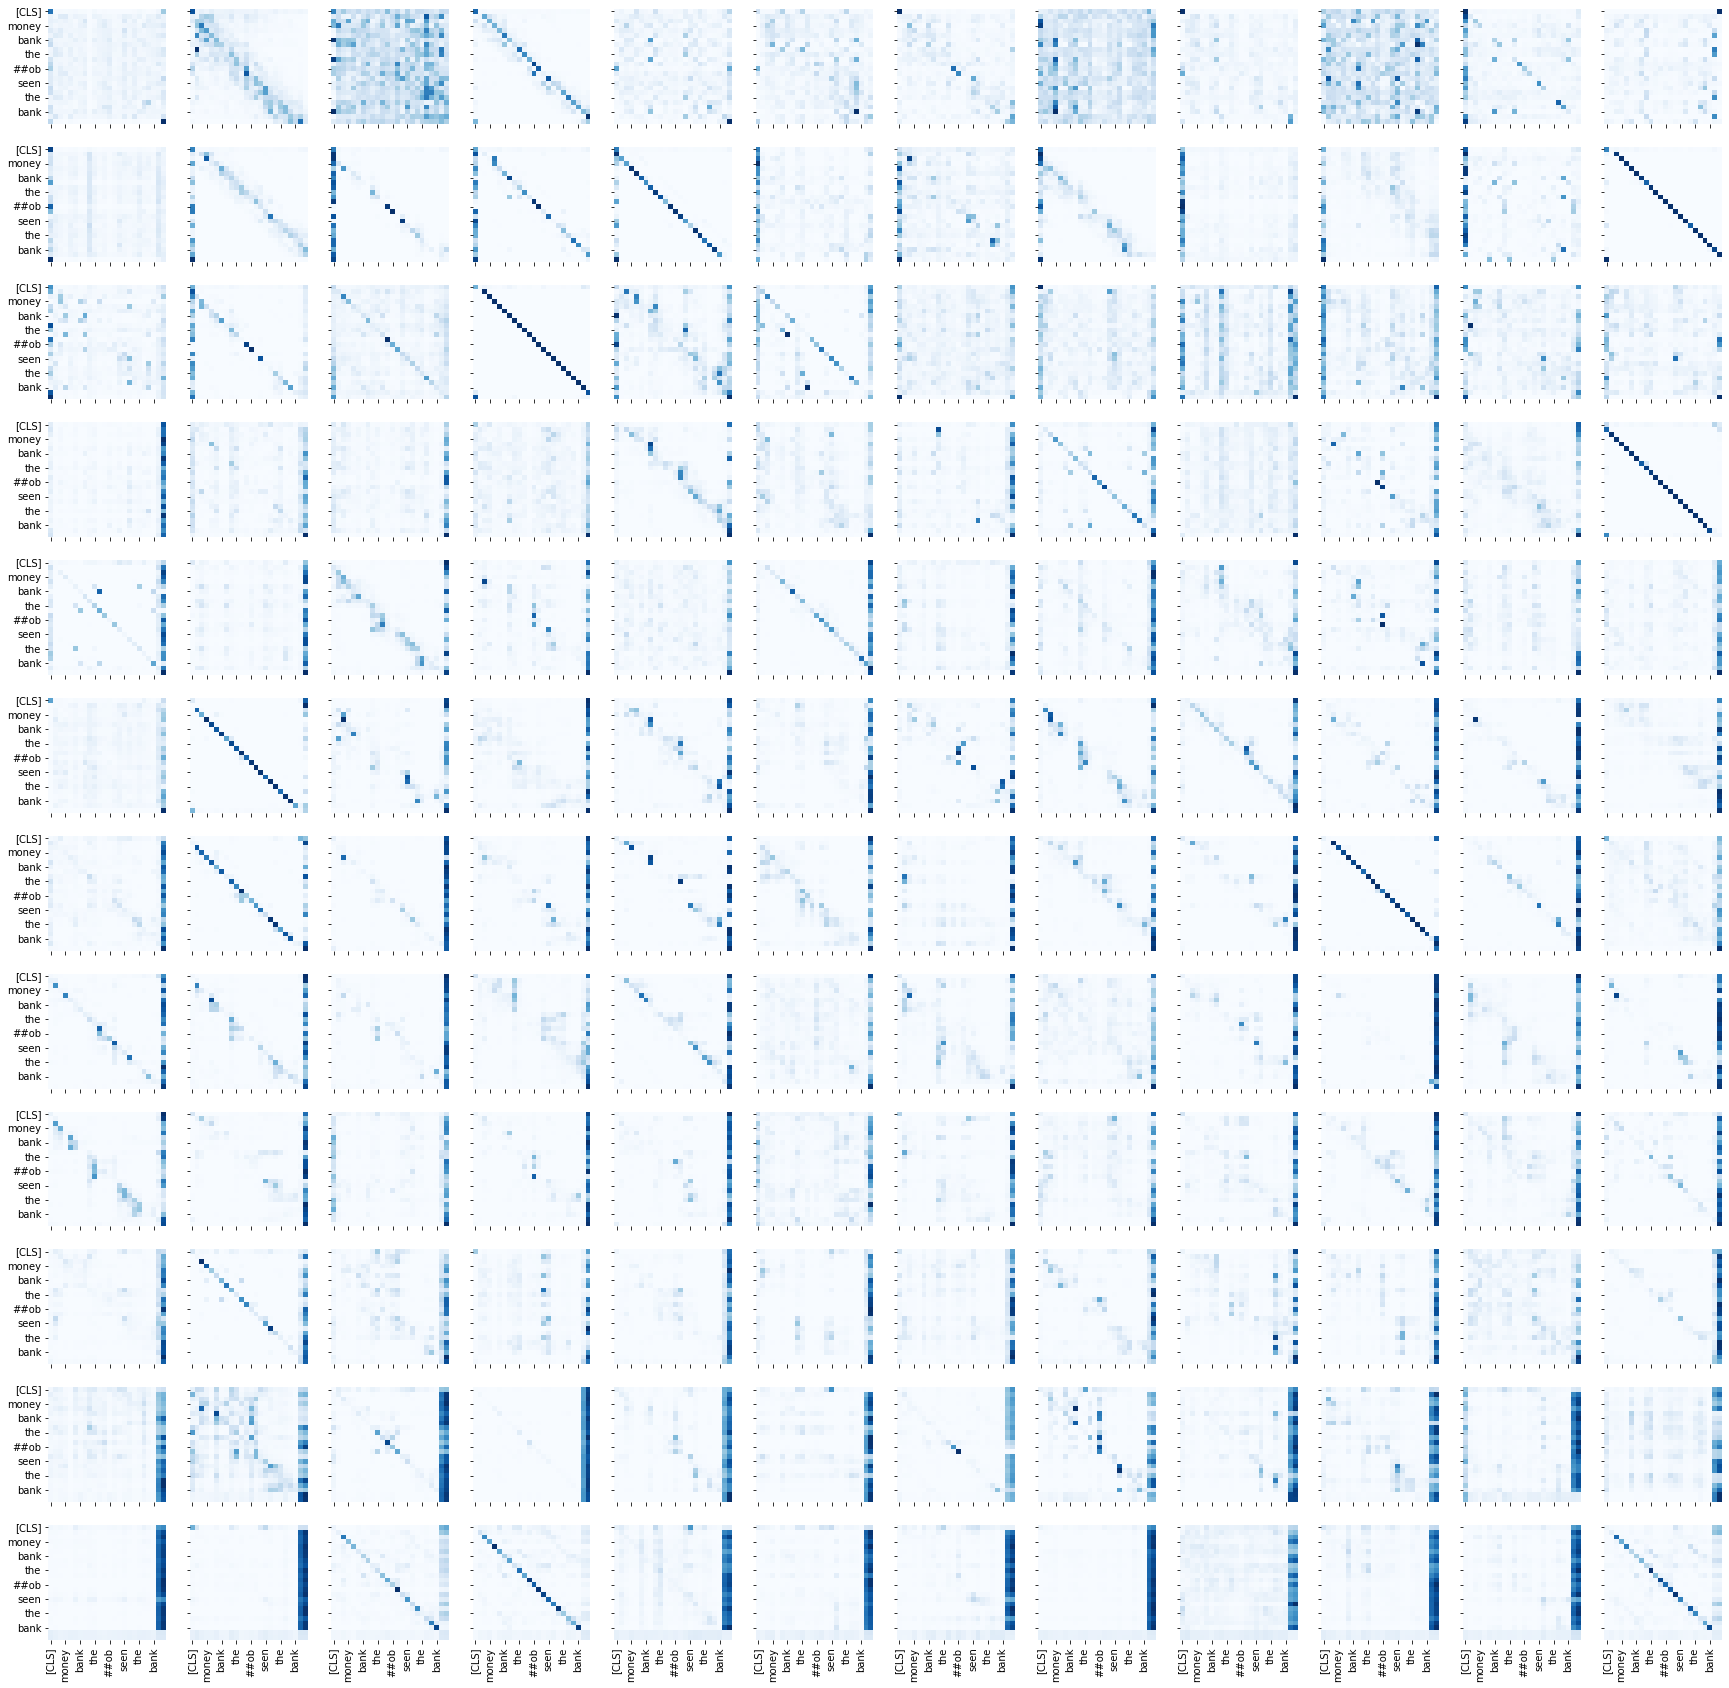

In [40]:
# There 12x12 of these matrices in total, lets get a view of them all --> takes about 5 minutes to run 
f,ax = plt.subplots(12,12,figsize = (30,30),sharex=True,sharey=True)


for x,attention_layer in tqdm(enumerate( model_output.attentions)):
    for y,attention_head in  enumerate(attention_layer.squeeze()) : 
        #print(attention_head.shape)
        plot_attention_attention(matrix = attention_head, columns = cols, axis = ax[x,y])
plt.show()

# some of these will have very different attention scores --> each of the self attention heads attends to very different sentence patterns

# Fine Tuning Bert

We've now arrived at the fully connected layer of BERT : we are finetuning our model. 
You have already covered most of BERT basics in the previous section, 
this one will feel a bit more like traditional Machine Learning as we are essentially fitting a classifier to a trainning set

In [31]:
#  define tokenizer & model 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# turn the configuration for a 2 sentiment classification task
config = AutoConfig.from_pretrained('bert-base-cased')
config.num_labels = 2

model = AutoModelForSequenceClassification.from_config(config)


In [32]:
train, test = train_test_split(df, test_size=0.3, random_state=123)
test, val = train_test_split(test, test_size=0.5, random_state=123)

In [33]:
print(train.label.value_counts(normalize=True),'\n',
test.label.value_counts(normalize=True),'\n',
val.label.value_counts(normalize=True))

0    0.688953
1    0.311047
Name: label, dtype: float64 
 0    0.738983
1    0.261017
Name: label, dtype: float64 
 0    0.665541
1    0.334459
Name: label, dtype: float64


## Defining a dataset class to interact with the Huggingface Transformers

In [34]:
# Defining a Dataset object to put our data in


class BERTTutorialDataset(Dataset):
    """
    Special dataset class built on top of the torch Dataset class
    useful to have memory efficient dataloading tokenization batching and trainning.
    
    Huggingface can use these types of dataset as inputs and run all trainning/prediction on them. 
    """
    def __init__(self, input_data, sentiment_targets, tokenizer, max_len):
        """
        Basic generator function for the class.
        -----------------
        input_data : array
            Numpy array of string  input text to use for downstream task 
        sentiment_targets : 
            Numpy array of integers indexed in  the pytorch style of [0,C-1] with C being the total number of classes
            In our example this means the target sentiments should range from 0 to 2. 
        tokenizer  : Huggingface tokenizer 
            The huggingface tokenizer to use
        max_len : 
            The truncation length of the tokenizer 
        -------------------
        
        Returns : 
        
            Tokenized text with inputs, attentions and labels, ready for the Training script. 
        """
        self.input_data = input_data
        self.sentiment_targets = sentiment_targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        """
        Function required by torch huggingface to batch efficiently
        """
        return len(self.input_data)
    
    def __getitem__(self, item):
        text = str(self.input_data[item])
        target = self.sentiment_targets[item]
        # only difference with the previuous tokenization step is the encode-plus for special tokens
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation = True
        )
        return {
         # 'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(target, dtype=torch.long)
        }

In [35]:
# Creating our train-val-test datasets
MAX_LEN = 128
train_ds = BERTTutorialDataset(
    input_data=train['sentence'].to_numpy(),
        sentiment_targets=train['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
val_ds = BERTTutorialDataset(
    input_data=val['sentence'].to_numpy(),
        sentiment_targets=val['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

test_ds = BERTTutorialDataset(
    input_data=test['sentence'].to_numpy(),
        sentiment_targets=test['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )


In [36]:
# Define some accuracy measure ( helpful for the early stopping )
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
def compute_metrics(p):
    """
    Function to calculate accuracies and losses for the validation from the predicted outputs
    This is neccessary for the early stopping. 
    """
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


## Defining the training arguments

In [37]:
# Define trainning arguments 
training_args = TrainingArguments(
                                #Parameters to manage the output, saving & storing of the model you train 
                                output_dir='BERT_TUTORIAL_MODEL', overwrite_output_dir=True, evaluation_strategy="steps",
                                  save_total_limit=5, save_steps=50,load_best_model_at_end = True,
                                # Parameters determining how fast & for how long & against what metric your model learns
                                  num_train_epochs=50, weight_decay=1e-8,learning_rate=1e-5,
                                  eval_steps=50,metric_for_best_model='f1', per_device_train_batch_size=16, per_device_eval_batch_size=16,
                                # Parameters to speed up computation 
                                 no_cuda=False, # run on gpu if you have it 
                                 fp16=True, # half point precision
                                 gradient_accumulation_steps=4 # gradient acumulation
                                    ) 



In [38]:
torch.cuda.is_available()

True

### Lauching the training process 

Here you can choose whether :
* to launch the training process to finetune the final layer of the BERT classifier on the training data
* to use the model we have finetuned before this tutorial on the same data --> we will do this in the interst of time but feel free 
    to run it  while we explain the rest or over lunch and ask questions !

In [39]:
# If you want to reuse the trained model we fine-tuned for this tutorial it is simple, please run : 
model = AutoModelForSequenceClassification.from_pretrained('BERT_TUTORIAL_MODEL/checkpoint-750')

# instatiate Trainer class
trainer = Trainer(
    # Which model are you trainning and how
    model =model, args=training_args,
    # What data are you uing to train and validate
    train_dataset=train_ds, eval_dataset=val_ds,
    # How are you validating and when do you stop training
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)],
    compute_metrics=compute_metrics
)


Using amp half precision backend


In [40]:
trainer.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 295
  Batch size = 16


{'eval_loss': 0.5963194370269775, 'eval_accuracy': 0.847457627118644, 'eval_precision': 0.8006126188022443, 'eval_recall': 0.8127904205885857, 'eval_f1': 0.8062863897036291, 'eval_runtime': 14.2979, 'eval_samples_per_second': 20.632, 'eval_steps_per_second': 1.329}


{'eval_loss': 0.5963194370269775,
 'eval_accuracy': 0.847457627118644,
 'eval_precision': 0.8006126188022443,
 'eval_recall': 0.8127904205885857,
 'eval_f1': 0.8062863897036291,
 'eval_runtime': 14.2979,
 'eval_samples_per_second': 20.632,
 'eval_steps_per_second': 1.329}

***** Running Prediction *****
  Num examples = 295
  Batch size = 16


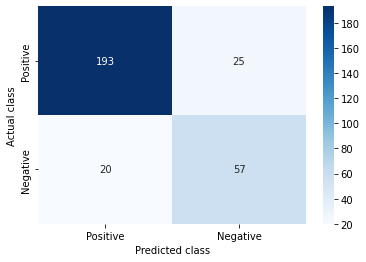

In [41]:
# If you want to evaluate the trainer run the code below

predictions = trainer.predict(test_ds)
output = np.argmax(predictions.predictions,1)

sns.heatmap(confusion_matrix(test.label.values,output),
            annot =confusion_matrix(test.label.values,output) ,
            fmt='g',cmap='Blues',xticklabels=['Positive','Negative'], yticklabels=['Positive','Negative'])#,labels = ['1','-1','0']
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.show()
#del predictions #--> We delete the predictions as we don't want to occupy too much gpu space

In [52]:
# averaged 'eval_f1': 0.80 --> That is about double what the previous model gave us 

In [53]:
# deleting all our objects to save GPU space
#del model
#del trainer
#del train_ds
#del val_ds
#del test_ds
#del tokenizer
torch.cuda.empty_cache()

# Results so far

| **Model name**        | **Loughram McDonald** | **Naive Bayes** | **Bert** |
|-----------------------|-----------------------|-----------------|----------|
| **Averaged F1 Score** | 0.2544                | 0.71          | 0.79     |

# Masked Language Modelling code

In [54]:
# We will not be running the code below as it would take a long time

```python
# Import the model & tokenizer

model_to_pretrain = BertForMaskedLM.from_pretrained('bert-base-cased')
tokenizer_for_pretraining = AutoTokenizer.from_pretrained("bert-base-cased")

# tokenize the inputs of the text 
inputs_for_pretraining = tokenizer_for_pretraining(df.sentence.tolist(), return_tensors='pt', max_length=32, truncation=True, padding='max_length')
inputs_for_pretraining['labels'] = inputs.input_ids.detach().clone()

# create random array of floats with equal dimensions to input_ids tensor
random_mask = torch.rand(inputs_for_pretraining.input_ids.shape)

# create mask array --> we hide 15% of the inputs for the masked language modelling task  
mask_arr = (random_mask < 0.15) * (inputs_for_pretraining.input_ids != 101) * \
           (inputs_for_pretraining.input_ids != 102) * (inputs_for_pretraining.input_ids != 0)

selection = []

for i in range(inputs_for_pretraining.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )
for i in range(inputs_for_pretraining.input_ids.shape[0]):
    inputs_for_pretraining.input_ids[i, selection[i]] = 103
    
    
class TUTORIALDataset(torch.utils.data.Dataset):
    """
    This is also a Dataset class as the Dataset class before 
    """
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)
    
    
dataset = TUTORIALDataset(inputs_for_pretraining)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Move model to device
model_to_pretrain.to(device)
# launch model training
model_to_pretrain.train()

args = TrainingArguments(
    output_dir='out',
    per_device_train_batch_size=16,
    num_train_epochs=2 #only 2 train epochs --> this is a safety check as this is a toy example, running a proper script with hyperparameters tuned for learning would take upwards of 10 hours ! 
)

MLM_trainer = Trainer(
    model=model_to_pretrain,
    args=args,
    train_dataset=dataset
)

MLM_trainer.train()
```

# 4. Visualisation

In [346]:
!pip install transformers_interpret


     ---------------------------------------- 1.3/1.3 MB 16.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ------------------------------------- 792.3/792.3 kB 25.2 MB/s eta 0:00:00
     ------------------------------------- 247.4/247.4 kB 14.8 MB/s eta 0:00:00
  Using cached captum-0.5.0-py3-none-any.whl (1.4 MB)
     ---------------------------------------- 98.7/98.7 kB ? eta 0:00:00
     ---------------------------------------- 51.6/51.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for transformers_interpret: filename=transformers_interpret-0.7.2-py3-none-any.whl size=26225 sha256=f313f9d316171f1edea2e0368c2a8b2b2526d38752ba4cd0d9003d687df67216
  Stored in directory: c:\users\drago\app

In [480]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

To visualise which words in each phrase are the most important for the prediction we will use the python package transformers_interpret 

We will compare explainability on : 
* Bert finetuned on textattack --> for a convenient baseline
* Bert finetuned on the financial phrasebank
* Finbert --> Bert pretrained and finetuned on the financial phrasebank 


In [481]:
fin_model_name = "ProsusAI/finbert"
model_name = "textattack/bert-base-uncased-SST-2"


fin_model = AutoModelForSequenceClassification.from_pretrained(fin_model_name)
fin_tokenizer = AutoTokenizer.from_pretrained(fin_model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [482]:
'Desktop/Python/OxfordManInstituteNLPConference/BERT_TUTORIAL_MODEL/checkpoint-750'

'Desktop/Python/OxfordManInstituteNLPConference/BERT_TUTORIAL_MODEL/checkpoint-750'

In [483]:
model = AutoModelForSequenceClassification.from_pretrained('BERT_TUTORIAL_MODEL/checkpoint-750')

In [484]:
# With both the model and tokenizer initialized we are now able to get explanations on an example text.
cls_explainer = SequenceClassificationExplainer(model,
                                                tokenizer)

fin_cls_explainer = SequenceClassificationExplainer(fin_model,
                                                    fin_tokenizer)

In [485]:
word_attributions = cls_explainer("Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing")
word_attributions = fin_cls_explainer("Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing")

In [486]:
cls_explainer.predicted_class_name

'LABEL_1'

In [487]:
bert_vis = cls_explainer.visualize()

In [488]:
fin_bert_vis = fin_cls_explainer.visualize()

# In summary 

| **Model name**        | **Loughram McDonald** | **Naive Bayes** | **Bert** | **FinBert** (From arxiv results) |
|-----------------------|-----------------------|-----------------|----------|-------------|
| **Averaged F1 Score** | 0.2544                | 0.71          | 0.80     |    0.8866   |
